In [1]:
#from imutils.video import VideoStream
import time
import cv2
import cv2.aruco as aruco
import numpy as np
from realsense_depth import *
# import the necessary packages
from threading import Thread
from utlities import *
from control_class import *
import math
import matplotlib.pyplot as plt

In [2]:
t =[]
throttle_value = []
pitch_value = []
roll_value = []
x_corr =[]
y_corr =[]
z_corr =[]
e_x = []
e_y =[]
e_z =[]
depth_value =[]

In [3]:
def drone_pose(frame ,matrix_coefficients, distortion_coefficients,id_no):
    
    MARKER_SIZE = 0.056
    rvec, tvec, markerPoints = cv2.aruco.estimatePoseSingleMarkers(corners[id_no], MARKER_SIZE, matrix_coefficients,distortion_coefficients)
    #frame = aruco_display(frame, corners[i]) 
    return frame,tvec[0][0][0],tvec[0][0][1],tvec[0][0][2]

In [11]:
# defining an empty custom dictionary 
# # defining an empty custom dictionary 
arucoDict = cv2.aruco.custom_dictionary(0, 4, 1)
# adding empty bytesList array to fill with 3 markers 
arucoDict.bytesList = np.empty(shape = (5, 2, 4), dtype = np.uint8)

# adding new markers
mybits = np.array([[0,1,0,0],[1,1,0,0],[1,0,1,0],[1,1,0,1]], dtype = np.uint8)
arucoDict.bytesList[0] = cv2.aruco.Dictionary_getByteListFromBits(mybits)
mybits = np.array([[1,1,1,1],[1,0,0,1],[1,0,0,1],[0,0,0,1],], dtype = np.uint8)
arucoDict.bytesList[1] = cv2.aruco.Dictionary_getByteListFromBits(mybits)
mybits = np.array([[0,0,0,1],[0,0,0,1],[1,0,1,0],[0,1,1,1]], dtype = np.uint8)
arucoDict.bytesList[2] = cv2.aruco.Dictionary_getByteListFromBits(mybits)
mybits = np.array([[0,0,0,0],[1,1,1,0],[1,0,1,1],[0,1,1,1],], dtype = np.uint8)
arucoDict.bytesList[3] = cv2.aruco.Dictionary_getByteListFromBits(mybits)
mybits = np.array([[0,0,1,0],[1,0,1,0],[0,0,0,0],[1,1,1,1]], dtype = np.uint8)
arucoDict.bytesList[4] = cv2.aruco.Dictionary_getByteListFromBits(mybits)

arucoParams = aruco.DetectorParameters_create()
calibration_matrix_path = "calibration_matrix.npy"
distortion_coefficients_path = "distortion_coefficients.npy"
    
k = np.load(calibration_matrix_path)
d = np.load(distortion_coefficients_path)
# initialize the video stream and allow the camera sensor to warm up
print("[INFO] starting video stream...")

# Change src accordingly
#vs = WebcamVideoStream(src=6).start()

time.sleep(2.0)

# loop over the frames from the video stream
dc = DepthCamera()
#track_img = vs.read()
first_time = True
xc , yc = -1,-1

num_not_detected = 0
eps = 0.1
#desired_pos = np.array([424,240,1.6])
desired_depth = 1.6



Kp_T = 30
Ki_T = 3
Kd_T = 2.5

I_P = 0
I_T = 0
I_R =0

e_P =0
e_R = 0
e_T = 0

Kp_R = 1
Ki_R = 0.2
Kd_R = 0.1

Kp_P = 1
Ki_P = 0.2
Kd_P = 0.1

command = Command("192.168.4.1")
for i in range(10):
    command.disarm()
    time.sleep(0.1)
# for i in range(10):
#     command.arm()
#     time.sleep(0.1)
command.takeoff()
for i in range(10):
    command.boxarm()
    print('box arm')
    time.sleep(0.1)

#desired_pos = np.array([420,230,desired_depth])
command.pitch = 1500
command.roll = 1500
command.throttle = 1500

prev_time = time.time()
try:
    while True:

        ret, color_frame = dc.get_frame()
        detected_markers = color_frame

        (corners, ids, rejected) = cv2.aruco.detectMarkers(color_frame,arucoDict, parameters=arucoParams)

        if len(corners)>0 and 0 in ids : 
                #print('Tracking drone')
                for i in range(0,len(ids)):
                    
                    if ( abs(corners[i][0][1][0] - corners[i][0][0][0]) > 100 or abs(corners[i][0][1][1] - corners[i][0][0][1]) > 100 ) :
                        print('error')
                    if ids[i] == 0:
                        detected_markers,xc,yc = aruco_display(color_frame,corners[i])
                        frame,x,y,z = drone_pose(color_frame,k,d,i)
                    #cv2.imwrite('det.jpg',  detected_markers)
                    num_not_detected = 0
        else :
            print('not detected')
            if num_not_detected > 10:
                print('Drone out of range')
                command.land()
                break
            num_not_detected +=1
            command.boxarm()
            time.sleep(0.1)
            continue
        
            
        if first_time:
            desired_pos = np.array([x,y,desired_depth])
            first_time = False
        else:
            depth = dc.get_depth(xc,yc)
            if( depth**2 > x**2 + y**2):
                z = np.sqrt(depth**2 - (x**2 + y**2))
            else :
                print('depth error')
            curr_pos = np.array([x,y,z])
            #print('depth = ',depth)
        
            if(np.linalg.norm(desired_pos - curr_pos) < eps):
                print('Reached Correct Depth')
                
                # for t in range(50):

                #     command.boxarm()
                #     ret, color_frame = dc.get_frame()
                #     cv2.imshow('Frame',color_frame)        
                #     time.sleep(0.1)
                # #cv2.destroyAllWindows()
                # command.land()
                # print('Landing')
                # break
            print('desired pos : ',desired_pos)
            print('curr_pos :', curr_pos )
            curr_time = time.time()

            t.append(curr_time)
            print('pitch')
            correction_x,I_P,e_P = PID(Kp_P,Ki_P,Kd_P,curr_pos[0],desired_pos[0],e_P,I_P,curr_time-prev_time)
            print('roll')
            correction_y,I_R,e_R = PID(Kp_R,Ki_R,Kd_R,curr_pos[1],desired_pos[1],e_R,I_R,curr_time-prev_time)
            print('throttle')
            correction_z,I_T,e_T = PID(Kp_T,Ki_T,Kd_T,curr_pos[2],desired_pos[2],e_T,I_T,curr_time-prev_time)
            depth_value.append(curr_pos[2])
            x_corr.append(correction_x)
            y_corr.append(correction_y)
            z_corr.append(correction_z)
            e_x.append(e_P)
            e_y.append(e_R)
            e_z.append(e_T)
            command.pitch += int(correction_x)
            command.roll += int(correction_y)
            command.throttle += int(correction_z)
            command.throttle = max(900,min(command.throttle,2100))
            command.pitch = max(900,min(command.pitch,2100))
            command.roll = max(900,min(command.roll,2100))
            print(command.pitch,command.roll,command.throttle)
            throttle_value.append(command.throttle)
            pitch_value.append(command.pitch)
            roll_value.append(command.roll)
            command.send()
            cv2.imshow("Frame", detected_markers)

            
        key = cv2.waitKey(1) & 0xFF
        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            break
        curr_time = time.time()
        fps = 1/(curr_time-prev_time)
        prev_time = curr_time
        print('fps = ',fps)
        # Restricting FPS
    #time.sleep(0.010)

except KeyboardInterrupt:
    command.land()

    
dc.release()
cv2.destroyAllWindows()
#vs.stop()


[INFO] starting video stream...
DepthCamera
box arm
box arm
box arm
box arm
box arm
box arm
box arm
box arm
box arm
box arm
fps =  9.547981160380344
Reached Correct Depth
desired pos :  [-1.08622341 -0.27782952  1.6       ]
curr_pos : [-1.09992418 -0.22635901  1.53510021]
pitch
-0.013700766488677685 -0.00016426596761448997 -0.022854521250294017
roll
0.051470508492335365 0.0006171080200578838 0.0858589795741457
throttle
-1.9469935772301827 -0.011671784354810236 -2.7065156124516827
1500 1500 1496
fps =  6.616529397567174
desired pos :  [-1.08622341 -0.27782952  1.6       ]
curr_pos : [-1.09844357 -0.18560773  1.42148088]
pitch
-0.012220163097573566 -0.0003471233456913515 0.001978942836477465
roll
0.09222178590025215 0.001997076015299632 0.054467286099868076
throttle
-5.35557357989096 -0.051741059007577465 -3.7965292952826157
1500 1500 1487
fps =  11.223929803341246
desired pos :  [-1.08622341 -0.27782952  1.6       ]
curr_pos : [-1.11124926 -0.16033388  1.385102  ]
pitch
-0.0250258444526

In [12]:
print(len(t))
print(len(throttle_value))
print(len(pitch_value))
print(len(roll_value))
print(len(depth_value))
print(len(x_corr))
print(len(y_corr))
print(len(z_corr))
print(len(e_x))
print(len(e_y))
print(len(e_z))

642
642
642
642
642
642
642
642
642
642
642


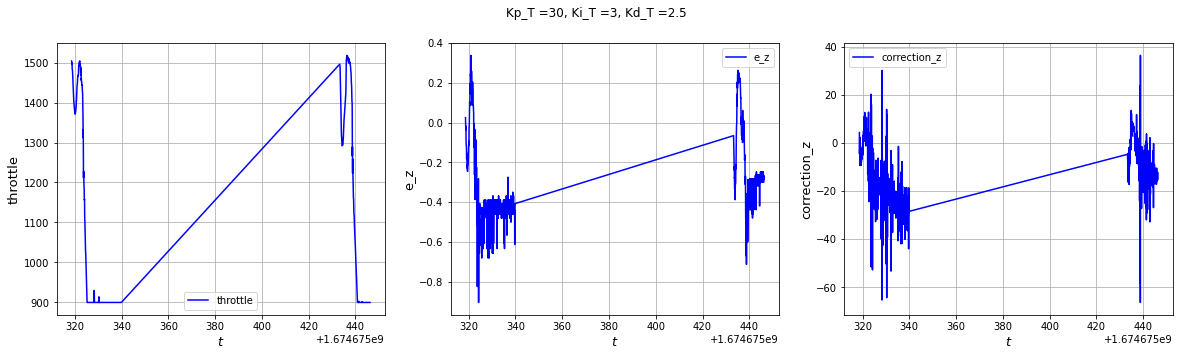

In [13]:
#ploting
f,ax = plt.subplots(1,3,figsize=(20,5))
f.suptitle(f'Kp_T ={Kp_T}, Ki_T ={Ki_T}, Kd_T ={Kd_T}')
ax[0].plot(t,throttle_value,'b',label ='throttle')
ax[0].set_xlabel('$t$',fontsize=13)
ax[0].set_ylabel('throttle',fontsize=13)
ax[0].grid(True)
ax[0].legend()
ax[1].plot(t,e_z,'b',label='e_z')
ax[1].set_xlabel('$t$',fontsize=13)
ax[1].set_ylabel('e_z',fontsize=13)
ax[1].grid(True)
ax[1].legend()
ax[2].plot(t,z_corr,'b',label ='correction_z')
ax[2].set_xlabel('$t$',fontsize=13)
ax[2].set_ylabel('correction_z',fontsize=13)
ax[2].grid(True)
ax[2].legend()
str ="image/"+f'Kp_T ={Kp_T}, Ki_T ={Ki_T}, Kd_T ={Kd_T}'+'.png'
f.savefig(str)

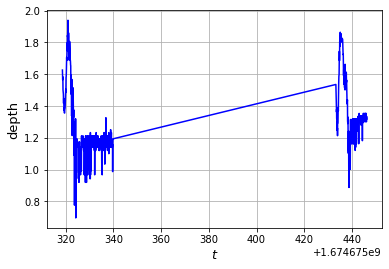

<Figure size 432x288 with 0 Axes>

In [14]:
plt.plot(t,depth_value,'b',label ='depth')
plt.xlabel('$t$',fontsize=13)
plt.ylabel('depth',fontsize=13)
plt.grid(True)
plt.show()
str ="image/"+f'depth during Kp_T ={Kp_T}, Ki_T ={Ki_T}, Kd_T ={Kd_T}'+'.png'
plt.savefig(str)

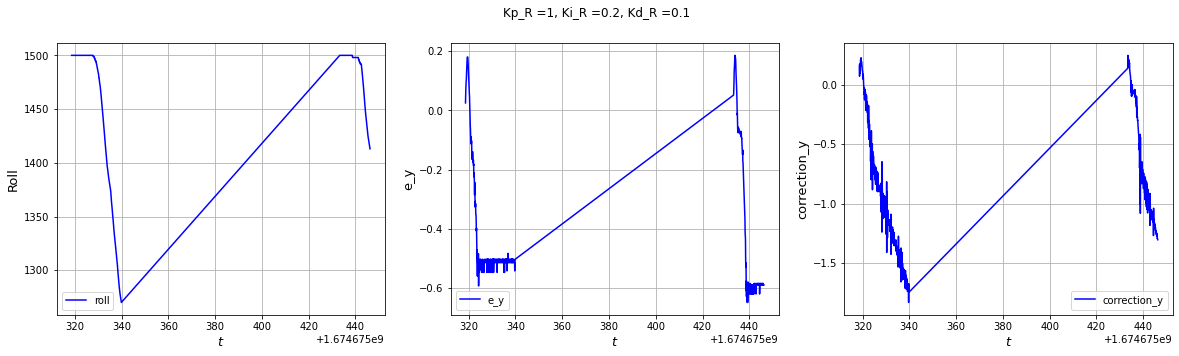

In [15]:
#ploting
f,ax = plt.subplots(1,3,figsize=(20,5))
f.suptitle(f'Kp_R ={Kp_R}, Ki_R ={Ki_R}, Kd_R ={Kd_R}')
ax[0].plot(t,roll_value,'b',label ='roll')
ax[0].set_xlabel('$t$',fontsize=13)
ax[0].set_ylabel('Roll',fontsize=13)
ax[0].grid(True)
ax[0].legend()
ax[1].plot(t,e_y,'b',label='e_y')
ax[1].set_xlabel('$t$',fontsize=13)
ax[1].set_ylabel('e_y',fontsize=13)
ax[1].grid(True)
ax[1].legend()
ax[2].plot(t,y_corr,'b',label ='correction_y')
ax[2].set_xlabel('$t$',fontsize=13)
ax[2].set_ylabel('correction_y',fontsize=13)
ax[2].grid(True)
ax[2].legend()
st ="image/"+f'Kp_R ={Kp_R}, Ki_R ={Ki_R}, Kd_R ={Kd_R}'+'.png'
f.savefig(st)

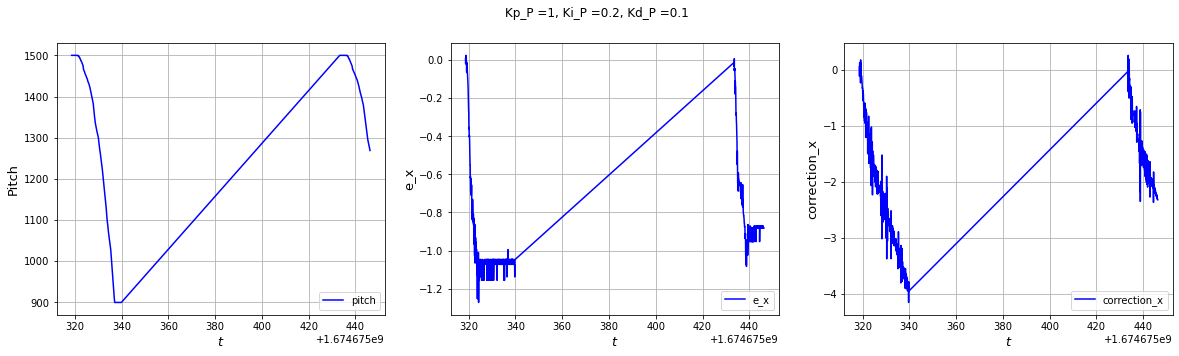

In [16]:
#ploting
f,ax = plt.subplots(1,3,figsize=(20,5))
f.suptitle(f'Kp_P ={Kp_P}, Ki_P ={Ki_P}, Kd_P ={Kd_P}')
ax[0].plot(t,pitch_value,'b',label ='pitch')
ax[0].set_xlabel('$t$',fontsize=13)
ax[0].set_ylabel('Pitch',fontsize=13)
ax[0].grid(True)
ax[0].legend()
ax[1].plot(t,e_x,'b',label='e_x')
ax[1].set_xlabel('$t$',fontsize=13)
ax[1].set_ylabel('e_x',fontsize=13)
ax[1].grid(True)
ax[1].legend()
ax[2].plot(t,x_corr,'b',label ='correction_x')
ax[2].set_xlabel('$t$',fontsize=13)
ax[2].set_ylabel('correction_x',fontsize=13)
ax[2].grid(True)
ax[2].legend()
st ="image/"+f'Kp_P ={Kp_P}, Ki_P ={Ki_P}, Kd_P ={Kd_P}'+'.png'
f.savefig(st)